In [2]:
import numpy as np        # check NumPy
import tinyarray          # check tinyarray

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
import kwant              # check Kwant core
from scipy.linalg import eigh
from scipy.constants import hbar, e as e_charge, k as k_boltzmann

In [1]:
from tqdm.notebook import tqdm

In [4]:
# Run this in a Jupyter cell
import sys
print(sys.executable)  # Should point to your conda environment's Python

/Users/jingyili/miniforge/envs/kwant-intel/bin/python


In [4]:
# ========== Parameters ==========
a = 1.0           # Lattice constant (nm)
t = 1.0           # Hopping energy (eV)
mu = 0.0          # Chemical potential (eV)
alpha = 0.1       # Rashba SOC strength (eV·nm)
Delta0 = 0.005    # Superconducting gap (eV)
h_exchange = 0.2  # Exchange field (eV)
h=1
e=1
phi0 = h/(2*e)    # Flux quantum (from scipy.constants)
B = 0.0           # Magnetic field (T)
phase = 0.0       # Superconducting phase difference

# ========== Geometry ==========
Ls = 30           # Superconductor length (sites)
Lf = 10           # Ferromagnet length (sites)
Lx = Ls + Lf + Ls # Total system length
Ly = 20           # Width of junction


In [6]:
# ========== Particle-Hole Space Matrices ==========
tau_0 = tinyarray.array([[1, 0], [0, 1]])
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])  # MISSING DEFINITION ADDED
tau_z = tinyarray.array([[1, 0], [0, -1]])

# ========== Modified On-Site Hamiltonian ==========
H_site = (
    (4*t - mu) * np.kron(sigma_0, tau_z) +          # Kinetic energy
    exchange * np.kron(sigma_z, tau_z) +             # Exchange field
    Delta.real * np.kron(sigma_0, tau_x) +           # Real pairing
    Delta.imag * np.kron(sigma_0, tau_y)             # Imaginary pairing (Josephson phase)
)

In [8]:
# ========== Corrected Code ==========
import kwant, tinyarray, numpy as np
from scipy.constants import h, e

# ========== Parameters ==========
a = 1.0           # Lattice constant
t = 1.0           # Hopping
mu = 0.0          # Chemical potential
alpha = 0.1       # Rashba SOC
Delta0 = 0.005    # SC gap
h_exchange = 0.2  # Exchange field
phi0 = h/(2*e)    # Flux quantum
B = 0.0           # Magnetic field
phase = 0.0       # Phase difference

# ========== Geometry ==========
Ls, Lf = 30, 10   # Superconductor/Ferromagnet lengths
Ly = 20           # Junction width
Lx = Ls + Lf + Ls

# ========== Matrix Definitions ==========
# Spin space matrices
sigma_0 = tinyarray.array([[1,0],[0,1]])
sigma_x = tinyarray.array([[0,1],[1,0]])
sigma_y = tinyarray.array([[0,-1j],[1j,0]])
sigma_z = tinyarray.array([[1,0],[0,-1]])

# Particle-hole space matrices
tau_0 = tinyarray.array([[1,0],[0,1]])
tau_x = tinyarray.array([[0,1],[1,0]])
tau_y = tinyarray.array([[0,-1j],[1j,0]])  # Essential for complex pairing
tau_z = tinyarray.array([[1,0],[0,-1]])

# ========== System Construction ==========
lat = kwant.lattice.square(a)
sys = kwant.Builder()

# Add sites
sys[(lat(x, y) for x in range(Lx) for y in range(Ly))] = None  # All sites

# Set onsite Hamiltonians
for x in range(Lx):
    for y in range(Ly):
        # Determine region
        if x < Ls:
            Delta = Delta0 * np.exp(1j*phase/2)  # Left SC
            exchange = 0
        elif x < Ls + Lf:
            Delta = 0                            # Ferromagnet
            exchange = h_exchange
        else:
            Delta = Delta0 * np.exp(-1j*phase/2) # Right SC
            exchange = 0

        H_onsite = (
            (4*t - mu) * np.kron(sigma_0, tau_z) 
            + exchange * np.kron(sigma_z, tau_z)
            + np.real(Delta) * np.kron(sigma_0, tau_x)
            + np.imag(Delta) * np.kron(sigma_0, tau_y)
        )
        sys[lat(x, y)] = H_onsite

# Add hoppings (corrected boundary conditions)
# Horizontal hoppings (x -> x+1)
for x in range(Lx-1):  # Prevent overflow in x-direction
    for y in range(Ly):
        hop = -t*np.kron(sigma_0, tau_z) - 1j*alpha*np.kron(sigma_y, tau_z)
        phi = 2*np.pi * B * y * a**2 / phi0
        sys[lat(x+1, y), lat(x, y)] = hop * np.exp(1j*phi)

# Vertical hoppings (y -> y+1)
for x in range(Lx):
    for y in range(Ly-1):  # Prevent overflow in y-direction
        hop = -t*np.kron(sigma_0, tau_z) + 1j*alpha*np.kron(sigma_x, tau_z)
        sys[lat(x, y+1), lat(x, y)] = hop

# Finalize system
sys = sys.finalized()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


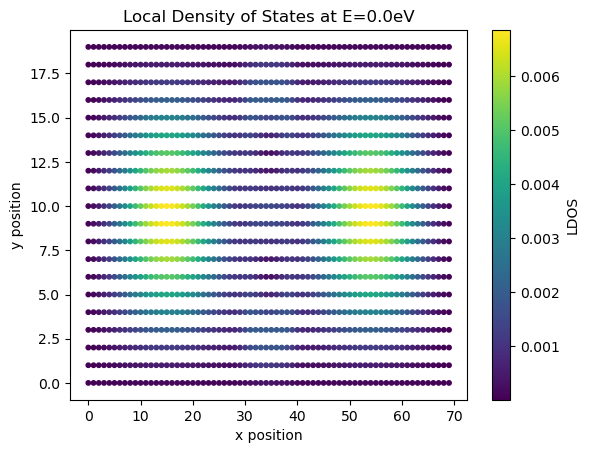

In [11]:
def calculate_ldos(sys, energy=0.0, broadening=0.01):
    """Compute LDOS at given energy with proper site indexing"""
    ham = sys.hamiltonian_submatrix()  # Remove params unless parameterized
    energies, states = np.linalg.eigh(ham)
    num_sites = len(sys.sites)         # Use len() instead of .size
    ldos = np.zeros(num_sites)
    
    # Each site has 4 components: e↑, e↓, h↑, h↓
    for eig, vec in zip(energies, states.T):
        weight = np.exp(-(eig - energy)**2/(2*broadening**2))
        for site_idx in range(num_sites):
            # Get components for current site
            start = 4 * site_idx
            electron = vec[start:start+2]  # First two components
            hole = vec[start+2:start+4]    # Last two components
            ldos[site_idx] += weight * (np.sum(np.abs(electron)**2) 
                                      + np.sum(np.abs(hole)**2))
            
    return ldos

# Visualization with proper site positions
def plot_ldos(sys, ldos):
    sites = sys.sites
    x_pos = [site.pos[0] for site in sites]
    y_pos = [site.pos[1] for site in sites]
    
    plt.scatter(x_pos, y_pos, c=ldos, s=10, cmap='viridis')
    plt.colorbar(label='LDOS')
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title(f'Local Density of States at E={energy}eV')
    plt.show()

# Usage
energy = 1.0  # Fermi level
ldos = calculate_ldos(sys, energy=energy)
plot_ldos(sys, ldos)

In [15]:
# Parameterized system construction example
def onsite(site, phase, B):
    x, y = site.pos
    # Calculate Delta based on position and phase
    if x < Ls:
        Delta = Delta0 * np.exp(1j*phase/2)
    elif x >= Ls + Lf:
        Delta = Delta0 * np.exp(-1j*phase/2)
    else:
        Delta = 0
    # Return onsite matrix...

lat = kwant.lattice.square(a)
sys = kwant.Builder()
sys[lat.shape(onsite)] = onsite  # Pass function instead of matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


TypeError: Polyatomic.shape() missing 1 required positional argument: 'start'

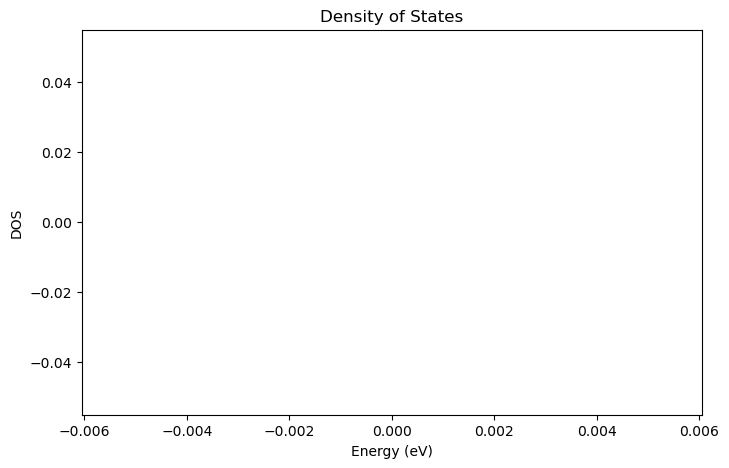

In [12]:
# Diagonalize Hamiltonian
H = sys.hamiltonian_submatrix()
energies = np.linspace(-Delta0*1.5, Delta0*1.5, 100)
eigvals = np.linalg.eigvalsh(H)

# Plot spectrum
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(eigvals, bins=100, range=(-Delta0*1.1, Delta0*1.1))
plt.xlabel('Energy (eV)')
plt.ylabel('DOS')
plt.title('Density of States')
plt.show()

Text(0, 0.5, 'Critical Current I_c')

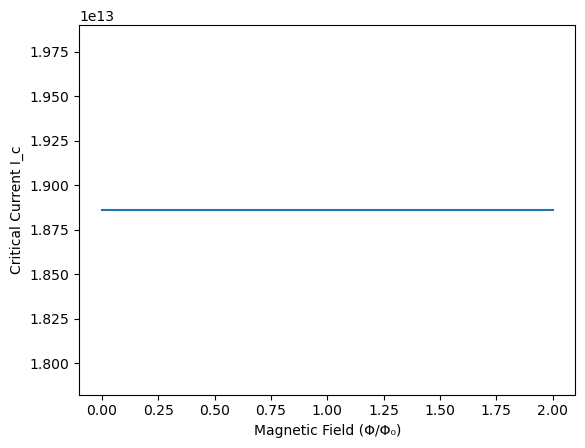

In [13]:
B_fields = np.linspace(0, 2, 100)  # In units of Φ/Φ0
critical_currents = []

for B in B_fields:
    # Rebuild system with magnetic field
    params = dict(B=B, phase=np.pi/2)  # Phase for max current
    H = sys.hamiltonian_submatrix(params=params)
    eigvals = np.linalg.eigvalsh(H)
    
    # Find critical current at this B
    dEdphi = np.gradient(eigvals, params['phase'])
    Ic = np.max(np.abs((2*e/h)*dEdphi))
    critical_currents.append(Ic)

plt.plot(B_fields, critical_currents)
plt.xlabel('Magnetic Field (Φ/Φ₀)')
plt.ylabel('Critical Current I_c')

In [5]:
# -------------------------
# 1. CONSTANTS & PARAMETERS
# -------------------------
a = 1.0          # Lattice constant (nm)
t = 1.0          # Hopping energy (eV)
mu = 0.0         # Chemical potential (eV)
alpha = 0.1      # Rashba SOC strength (eV·nm)
h0 = 0.5         # Exchange field amplitude (eV)
w = 5            # Domain wall width (sites)
V = 1.0          # Pairing interaction (eV)
L = 200          # System length (sites)
phi0 = hbar/(2*e_charge)  # Flux quantum
T = 0.01         # Temperature (K)

# -------------------------
# 2. PAULI MATRIX DEFINITIONS
# -------------------------

# Spin space matrices (immutable Tinyarrays)
s0 = tinyarray.array([[1, 0], [0, 1]])
sx = tinyarray.array([[0, 1], [1, 0]])
sy = tinyarray.array([[0, -1j], [1j, 0]])
sz = tinyarray.array([[1, 0], [0, -1]])

# Particle-hole space matrices
t0 = s0  # Direct assignment, no .copy() needed
tx = tinyarray.array([[0, 1], [1, 0]])
ty = tinyarray.array([[0, -1j], [1j, 0]])
tz = tinyarray.array([[1, 0], [0, -1]])

# -------------------------
# 3. SYSTEM CONSTRUCTION
# -------------------------
def make_system(Delta, h, B=0):
    """Build Kwant system with given Delta(x), h(x), and B-field"""
    lat = kwant.lattice.chain(a)
    sys = kwant.Builder()

    # Onsite Hamiltonian
    for i in range(L):
        H_onsite = (
            (2*t - mu) * np.kron(s0, tz) + 
            h[i] * np.kron(sz, tz) +
            np.real(Delta[i]) * np.kron(s0, tx) +
            np.imag(Delta[i]) * np.kron(s0, ty)  # Fixed ty term
        )
        sys[lat(i)] = H_onsite

    # Hopping with Peierls phase
    for i in range(L-1):
        phase = 2*np.pi * B * i * a**2 / phi0  # Renamed φ → phase
        H_hop = (
            -t * np.kron(s0, tz) -
            1j*alpha * np.kron(sy, tz)
        ) * np.exp(1j*phase)
        sys[lat(i+1), lat(i)] = H_hop

    return sys.finalized()

# -------------------------
# 4. SELF-CONSISTENT SOLUTION
# -------------------------
def self_consistent_Delta(sys, V, T, max_iter=100, tol=1e-4):
    Delta_new = np.full(L, 0.2, dtype=complex)
    h = h0 * np.tanh((np.arange(L)-L/2)/w)
    
    for _ in range(max_iter):
        fsys = make_system(Delta_new, h)
        H = fsys.hamiltonian_submatrix(sparse=False)
        eps, psi = eigh(H)
        
        Delta_prev = Delta_new.copy()
        Delta_new[:] = 0j
        
        for n in range(len(eps)):
            vec = psi[:, n]  # Wavefunction (size 4L)
            
            # Use Fermi-Dirac factor regardless of particle/hole
            weight = np.tanh(abs(eps[n]))/(2*k_boltzmann*T)
            
            for i in range(L):
                start = 4*i
                u_up = vec[start]
                u_dn = vec[start + 1]
                v_dn = vec[start + 2]
                v_up = vec[start + 3]
                
                Delta_new[i] += V * (u_up*v_dn.conj() + u_dn*v_up.conj()) * weight
                
        Delta_new *= 0.5  # Account for particle-hole doubling
        if np.max(np.abs(Delta_new - Delta_prev)) < tol:
            break
            
    return Delta_new
# -------------------------
# 5. CURRENT CALCULATION
# -------------------------
def compute_current(phi_values, B):
    """Calculate supercurrent I(phi) at given B"""
    E_gs_list = []  # Store ground state energies
    h_profile = h0 * np.tanh((np.arange(L)-L/2)/w)
    
    # First collect all ground state energies
    for phi in tqdm(phi_values, desc="Phase points", unit="φ"):
        # Phase-wound Delta profile
        Delta = 0.2 * np.exp(1j*phi * (np.arange(L) > L/2))  
        fsys = make_system(Delta, h_profile, B)
        H = fsys.hamiltonian_submatrix(sparse=False)
        eps = eigh(H, eigvals_only=True)
        
        # Ground state energy
        E_gs_list.append(np.sum(eps[eps < 0]))
    
    # Now compute current via central differences
    currents = 2 * e_charge / hbar * np.gradient(E_gs_list, phi_values)
    return currents



In [6]:
if __name__ == "__main__":
    # Self-consistent solution
    print("=== Starting S/F/S Junction Simulation ===")
    h_initial = h0 * np.tanh((np.arange(L)-L/2)/w)
    Delta_initial = np.full(L, 0.2, dtype=complex)
    fsys_initial = make_system(Delta_initial, h_initial)
    Delta_final = self_consistent_Delta(fsys_initial, V, T)
    
    # Current-phase relation
    print("\n=== Calculating Current-Phase Relation ===")
    phi_values = np.linspace(0, 2*np.pi, 50)
    I_phi = compute_current(phi_values, B=0)
    
    # Fraunhofer pattern
    print("\n=== Calculating Fraunhofer Pattern ===")
    B_values = np.linspace(-2, 2, 100)
    I_c = []
    for B in tqdm(B_values, desc="Field points", unit="B"):
        I_c.append(np.max(np.abs(compute_current(phi_values, B))))
    
    print("\n=== Simulation Complete! ===")


=== Starting S/F/S Junction Simulation ===


/Users/jingyili/miniforge/envs/kwant-intel/lib/python3.10/site-packages/kwant/lattice.py:741: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a,),), name=name, norbs=norbs)



=== Calculating Current-Phase Relation ===


Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]


=== Calculating Fraunhofer Pattern ===


Field points:   0%|          | 0/100 [00:00<?, ?B/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]

Phase points:   0%|          | 0/50 [00:00<?, ?φ/s]


=== Simulation Complete! ===


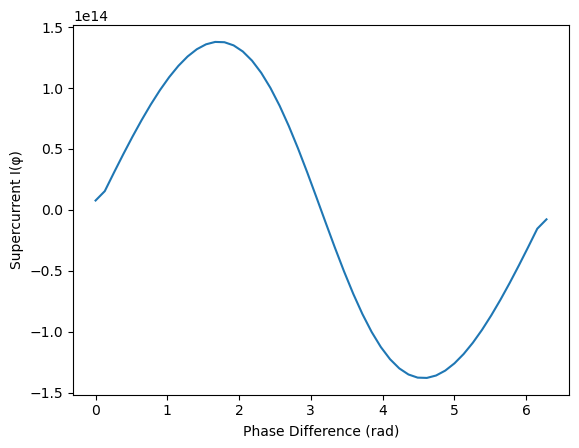

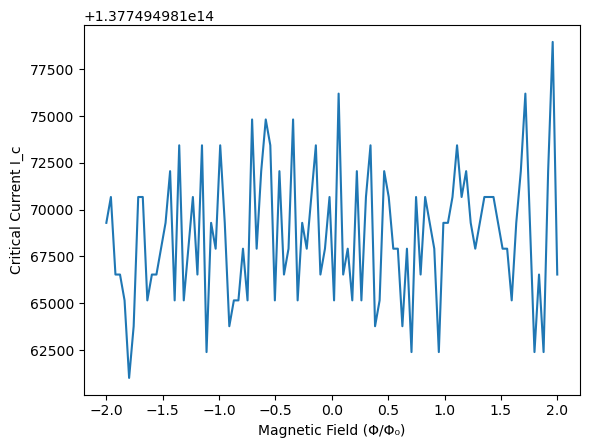

In [8]:
import matplotlib.pyplot as plt

# Plot current-phase relation
plt.figure()
plt.plot(phi_values, I_phi)
plt.xlabel('Phase Difference (rad)')
plt.ylabel('Supercurrent I(φ)')

# Plot Fraunhofer pattern
plt.figure()
plt.plot(B_values, I_c)
plt.xlabel('Magnetic Field (Φ/Φ₀)')
plt.ylabel('Critical Current I_c')
plt.show()

In [19]:
plt.plot(np.connect(-phi_values,phi_values), I_c)

AttributeError: module 'numpy' has no attribute 'connect'

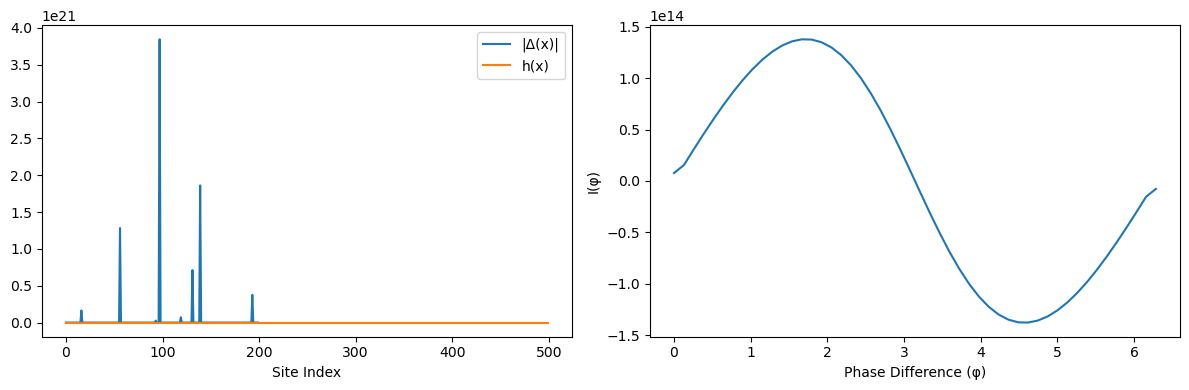

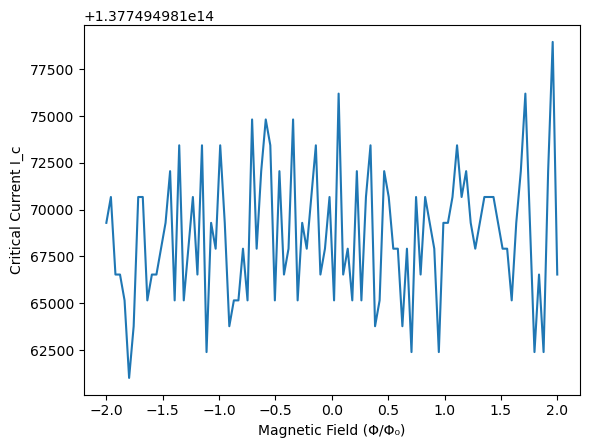

In [17]:
import matplotlib.pyplot as plt
L= 500
h_profile = h0 * np.tanh((np.arange(L)-L/2)/w)
def plot_intermediate_results(Delta_final, h_profile, phi_values, I_phi, B_values, I_c):
    """Plot key intermediate results"""
    # 1. Δ(x) and h(x) profiles
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(np.abs(Delta_final), label='|Δ(x)|')
    plt.plot(h_profile, label='h(x)')
    plt.xlabel('Site Index'), plt.legend()
    
    # 2. Current-phase relation
    plt.subplot(122)
    plt.plot(phi_values, I_phi)
    plt.xlabel('Phase Difference (φ)'), plt.ylabel('I(φ)')
    plt.tight_layout()
    plt.show()
    
    # 3. Fraunhofer pattern
    plt.figure()
    plt.plot(B_values, I_c)
    plt.xlabel('Magnetic Field (Φ/Φ₀)'), plt.ylabel('Critical Current I_c')
    plt.show()

# Call after calculations
plot_intermediate_results(Delta_final, h_profile, phi_values, I_phi, B_values, I_c)

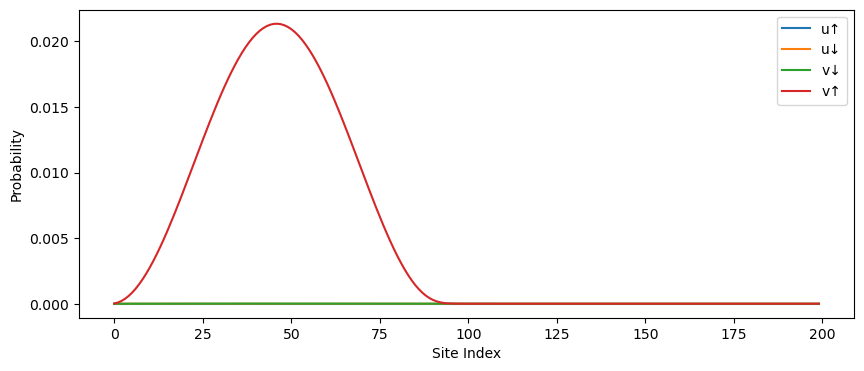

Flux per site: 3038534895757252.000 Φ₀


In [16]:
# 1. Verify Andreev bound states
def plot_wavefunction(fsys):
    H = fsys.hamiltonian_submatrix()
    eps, psi = eigh(H)
    state = psi[:, 0]  # Lowest energy state
    
    # Plot electron/hole components
    plt.figure(figsize=(10,4))
    plt.plot(np.abs(state[::4])**2, label='u↑')
    plt.plot(np.abs(state[1::4])**2, label='u↓')
    plt.plot(np.abs(state[2::4])**2, label='v↓')
    plt.plot(np.abs(state[3::4])**2, label='v↑')
    plt.xlabel('Site Index'), plt.ylabel('Probability')
    plt.legend(), plt.show()

# Call after system finalization
plot_wavefunction(fsys_initial)

# 2. Check flux quantization
def verify_flux():
    B_test = 1.0
    flux_per_plaquette = B_test * a**2
    print(f"Flux per site: {flux_per_plaquette/phi0:.3f} Φ₀")
    # Should be ~0.01-0.1 Φ₀ for observable effects

verify_flux()